In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from pathlib import Path
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union, Dict
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
from bert_score import BERTScorer
warnings.filterwarnings("ignore")
from copy import deepcopy
from openai import OpenAI
from babilong.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.babilong.babilong_utils import compare_answers

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, insert_needle, get_start_of_generation_token

from src.attention_saver import GUIDEModel
# from src.influence import Influence
import json
import regex as re

tqdm.pandas()
import scienceplots
plt.style.use(['science','no-latex', 'grid'])

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)

# TEMPLATE = "You are a helpful assistant that answers in JSON. Here's the json schema you must adhere to:\n\n<schema>\n{schema}\n</schema>\n\n{noise}\n\n{content}\n\nDo not output anything else than the JSON."

In [4]:
base_path = "data/study-04-json/google/gemma-2-2b-it/05/checkpoints/delta={delta}_large_upper.parquet"
checkpoints_path = "data/study-04-json/google/gemma-2-2b-it/05/checkpoints/delta={delta}_large_upper.parquet"


In [ ]:
start+of_generation_tag = get_start_of_generation_token('gemma')

In [5]:
all_df = []
import re

# pattern = r'\{(?:[^{}]+|(?R))+\}'
pattern = r"\{(.*)\}"

def get_text_whithin_braces(x):
    match = re.search(pattern, x, re.DOTALL)
    if match:
        return match.group(0)

    return None

def convert_to_json(x):
        if x is None:
            return None
        try:
            return json.loads(x)

        except:
            return None
    


# Find all matches


for delta in [0., 1., 2., 3.]:

    try:
        df = pd.read_parquet(base_path.format(delta= delta))
    except:
        df = pd.read_parquet(checkpoints_path.format(delta = delta))

    

    df['generated_text'] = df['generated_text']\
        .apply(lambda x: x.split('[/INST]')[1])
        
    df['generated_braces'] = df['generated_text']\
        .apply(get_text_whithin_braces)
    
    df['generated_json'] = df['generated_braces'].apply(convert_to_json)
            # lambda x:   x.replace("\n", '')\
            #             .replace('</s>', '')\
            #             .replace('\r', '')\
            #             .replace('          ', '')\
            #             .replace("<schema>", "")\
            #             .replace("</schema>", "")

    df['delta'] = fr'$\Delta$ = {delta}'
    if delta == 0:
        df['delta'] = "Raw prompt"
    all_df.append(df)

uppercase_df = pd.read_parquet("data/study-04-json/05/delta=0.0_uppercase.parquet")
uppercase_df['generated_text'] = uppercase_df['generated_text']\
    .apply(lambda x: x.split('[/INST]')[1])
    
uppercase_df['generated_braces'] = uppercase_df['generated_text']\
    .apply(get_text_whithin_braces)

uppercase_df['generated_json'] = uppercase_df['generated_braces'].apply(convert_to_json)
uppercase_df['delta'] = 'Uppercase'

all_df.append(uppercase_df)

IndexError: list index out of range

In [6]:

df

,generated_text,original_text,schema,context_length,book_id
22307,<bos><bos><start_of_turn>user\nYou are an assi...,Pai^/uhoiy 'EuTa%tcL+ or; SELECT POEMS: BEING ...,"{\n ""title"": ""title of the story (string)"",...",5999,002742599
13087,<bos><bos><start_of_turn>user\nYou are an assi...,"HENRY TH E T HI R D O F FRANCE, Stabb'd by a F...","{\n ""title"": ""title of the story (string)"",...",5995,003370470
32579,<bos><bos><start_of_turn>user\nYou are an assi...,"THE STEPMOTHER. A Tragi-Comedy, Acted with gre...","{\n ""title"": ""title of the story (string)"",...",5993,003493777
36224,<bos><bos><start_of_turn>user\nYou are an assi...,"TM-IWIT/BM^JTitus Andronicus. O K T H E Rape, ...","{\n ""title"": ""title of the story (string)"",...",5992,003354250
32065,<bos><bos><start_of_turn>user\nYou are an assi...,THE English Mounsieur. A COMEDY As it is Acted...,"{\n ""title"": ""title of the story (string)"",...",5991,001746559
...,...,...,...,...,...
36447,<bos><bos><start_of_turn>user\nYou are an assi...,"1 hTEniMOBLE SOVLDIER; A CONTRACT BROKEN, JUST...","{\n ""title"": ""title of the story (string)"",...",512,004077038
32124,<bos><bos><start_of_turn>user\nYou are an assi...,"THE CHANCES, A COMEDY: As it is ACTED at the T...","{\n ""title"": ""title of the story (string)"",...",509,003796217
24647,<bos><bos><start_of_turn>user\nYou are an assi...,"Xuckey Chance, O R A N ALDERMANS gmftaftt, A C...","{\n ""title"": ""title of the story (string)"",...",508,000252185
20988,<bos><bos><start_of_turn>user\nYou are an assi...,SATYR TO HIS M USE. the Author of ABSALOM & AC...,"{\n ""title"": ""title of the story (string)"",...",506,003255413


In [7]:
base_path_large = "data/study-04-json/05/delta={delta}_large.parquet"

for delta in [0., 1., 2., 3.]:

    try:
        df = pd.read_parquet(base_path_large.format(delta= delta))
    except:
        continue

    

    df['generated_text'] = df['generated_text']\
        .apply(lambda x: x.split('[/INST]')[1])
        
    df['generated_braces'] = df['generated_text']\
        .apply(get_text_whithin_braces)
    
    df['generated_json'] = df['generated_braces'].apply(convert_to_json)
            # lambda x:   x.replace("\n", '')\
            #             .replace('</s>', '')\
            #             .replace('\r', '')\
            #             .replace('          ', '')\
            #             .replace("<schema>", "")\
            #             .replace("</schema>", "")

    df['delta'] = fr'$\Delta$ = {delta}'
    if delta == 0:
        df['delta'] = "Raw prompt"
    all_df.append(df)

In [8]:
results_df = pd.concat(all_df)\
    .reset_index()\
    .rename(columns={"level_0": "text_index", "level_1": "epoch"})

In [9]:
results_df.loc[20]['generated_text']

' The given text appears to be a satirical poem about the idea of a commonwealth or a republic being superior to a monarchy. The poem uses various metaphors and imagery to make its point.\n\nThe poem begins by describing a satyr who is angry with the gods for creating a commonwealth instead of a monarchy. The satyr is depicted as a creature who loves to drink and party, and who is opposed to the idea of hard work and responsibility.\n\nThe poem then goes on to describe various other creatures who are also opposed to the idea of a commonwealth. These include a lion who is depicted as a lazy and drunken creature, and a bear who is depicted as a violent and destructive creature.\n\nThe poem also includes various metaphors and imagery that are meant to convey the idea that a commonwealth is a better form of government than a monarchy. For example, the poem describes the commonwealth as a "cloud" that is "gentle" and "awes" the angels, while a monarchy is depicted as a "throne" that is "har

In [10]:
fields = ['title', 'genre', 'characters', 'author','summary', "scenery", "date"]
i = 0

def score_json(x : Dict):
    if x is None:
        return 0
    
    
    score = 0
    for key in fields:
        if key == 'characters':
            if not key in x:
                continue

            if type(x['characters']) != list:
                continue

            for character in x['characters']:
                if not "name" in character:
                    break
                if not "description" in character:
                    break

            score += 1

        else:
            if not key in x:
                continue

            if type(x[key]) != str:
                continue

            score += 1

    return score/(max(len(fields), len(x))) 

def wrong_fields(x: Dict):
    if x is None:
        return 'not a json'
    
    wrong = []
    for key in fields:
        if key == 'characters':
            if not key in x:
                wrong.append(['characters', 'missing'])
                continue

            if type(x['characters']) != list:
                wrong.append(['characters', "not list"])
                continue

            for character in x['characters']:
                if not "name" in character:
                    wrong.append([key, 'incorrect type'])
                    break
                if not "description" in character:
                    wrong.append([key, 'incorrect type'])
                    break

        else:
            if not key in x:
                wrong.append([key, 'missing'])
                continue

            if type(x[key]) != str:
                wrong.append([key, 'incorrect type'])
                continue


    return wrong

In [11]:
results_df['wrong_values'] = results_df["generated_json"].apply(wrong_fields)

In [12]:
results_df['score'] = results_df['generated_json'].apply(score_json)

In [13]:
results_df['score'].any()

True

In [14]:
b = results_df.sample(1)
b['generated_json'].item(), b['score'].item()

({'title': 'The Governess',
  'genre': 'Romance',
  'characters': [{'name': 'The Governess',
    'description': "A poor girl who is hired as a governess for the Bellingham family's daughter."},
   {'name': 'Sir Oliver Bellingham',
    'description': "The father of the Bellingham family's daughter."},
   {'name': 'William', 'description': 'A friend of Sir Oliver Bellingham.'},
   {'name': 'Ralph', 'description': 'A friend of Sir Oliver Bellingham.'}],
  'author': 'Unknown',
  'summary': "The Governess is hired as a governess for the Bellingham family's daughter, but the daughter is not interested in learning and the governess is not interested in the job. The governess is also not interested in the advances of Sir Oliver Bellingham, who is married to a widow.",
  'date': '1647',
  'scenery': 'The story takes place in a poor country where the girl lives.'},
 1.0)

In [15]:
results_df['context_length'].sort_values()

2533      501
12669     501
10135     501
7601      501
5067      501
         ... 
12671    5998
14282    5999
15088    5999
13476    5999
12670    5999
Name: context_length, Length: 15894, dtype: int64

In [16]:
results_df['context_length_bins'] = pd.cut(
    results_df['context_length'],
    range(0,6500, 1000)
)


In [17]:
0.70/0.54

1.296296296296296

In [18]:
results_df['delta'] =results_df['delta'].astype(str)

In [19]:
hue_order = ['Raw prompt', "Uppercase", "$\Delta$ = 1.0", "$\Delta$ = 2.0", "$\Delta$ = 3.0"]

In [20]:
palette = {
    'Raw prompt': sns.color_palette("Blues", 5)[2],    # Darker Blue
    'Uppercase': sns.color_palette("Blues", 5)[3],    # Medium Blue
    "`Important' + uppercase": sns.color_palette("Blues", 5)[4],    # Medium Blue
    '$\\Delta$ = 1.0': sns.color_palette("Reds", 5)[1],        # Light Red
    '$\\Delta$ = 2.0': sns.color_palette("Reds", 5)[2],        # Medium Red
    '$\\Delta$ = 3.0': sns.color_palette("Reds", 5)[3],        # Darker Red
}

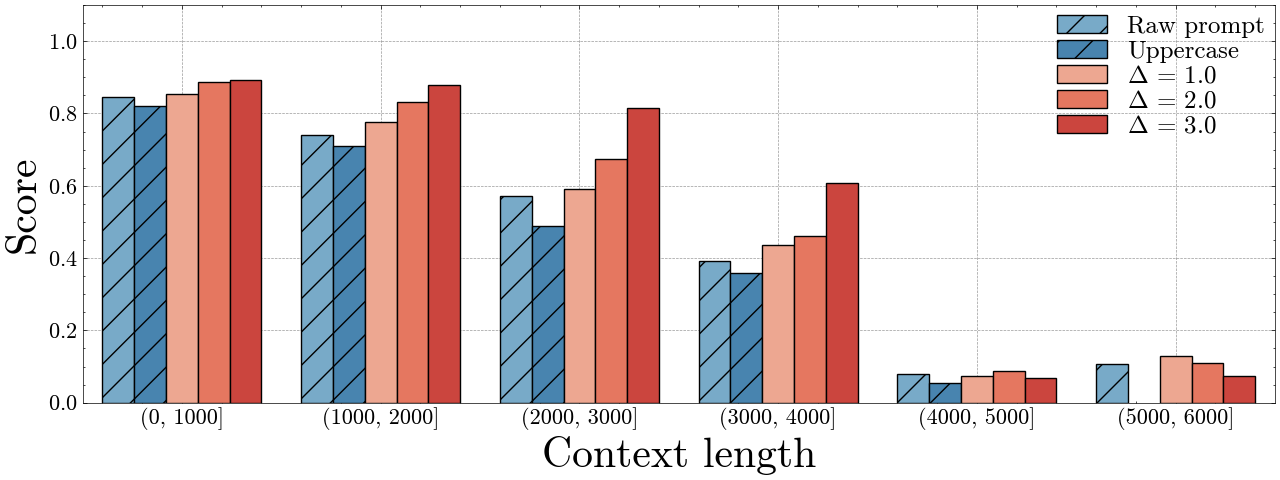

In [42]:
a = results_df.groupby(['context_length_bins', 'delta'])\
    .score\
    .mean()\
    .reset_index()
plt.figure(figsize = (13,5))

ax = sns.barplot(
    a,
    x = 'context_length_bins',
    y = 'score',
    hue = 'delta',
    palette = palette,
    hue_order=hue_order
)

for i, bar in enumerate(ax.patches):
    colors = bar.get_facecolor()
    is_blue = np.argmax(colors[0:3]) == 2
    is_red = np.argmax(colors[0:3]) == 0
    if is_blue:

        bar.set_hatch('/')  # Set the hatch pattern for each bar

    # else:
    #     bar.set_hatch('*') 

    bar.set_edgecolor('black')

label_fontsize = 30
legend_fontsize = 18
tick_fontsize = 16

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# legend = plt.legend(prop= {"size" : legend_fontsize})
# plt.setp(legend.get_title(),fontsize=legend_fontsize)

# ax.legend_.set_title(r"")
plt.xlabel("Context length", fontsize = label_fontsize)
plt.ylabel("Score", fontsize = label_fontsize)
plt.legend(frameon=False)
sns.move_legend(ax, labelspacing=0.1, loc='best', prop= {"size" : legend_fontsize}, borderaxespad=0.,)

# plt.grid()
plt.grid(alpha = 0.4,)

plt.ylim([0,1.1])
plt.xlim([-.5, 5.5])

plt.tight_layout()

# plt.savefig("img/json_delta_vs_ctx.pdf")
plt.show()

In [32]:
bar.getco

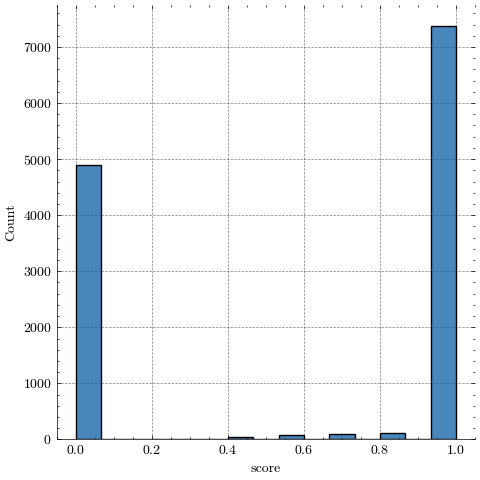

In [20]:
sns.displot(results_df['score'])